In [2]:
import os
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg
# Read in a image from torchvision

--2024-03-06 07:38:12--  https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg
Resolving segment-anything.com (segment-anything.com)... 13.35.7.12, 13.35.7.36, 13.35.7.124, ...
Connecting to segment-anything.com (segment-anything.com)|13.35.7.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 221810 (217K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>] 216.61K  --.-KB/s    in 0.01s   

2024-03-06 07:38:13 (19.6 MB/s) - ‘dog.jpg’ saved [221810/221810]



In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt
import torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)
img = torch.tensor(img, dtype=torch.float)
crop = torchvision.transforms.functional.crop(img, 600, 800, 300, 300)


torch.Size([3, 1365, 2048])


<ipython-input-4-179c277624ae>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float)


In [5]:


def extract_patch(image_tensor, patch_location, patch_size):
    """Extract a rectangular patch from the image tensor."""
    # Define patch coordinates
    patch_x, patch_y = patch_location

    # Extract the patch into a different variable
    extracted_patch = image_tensor[:,patch_x:patch_x+patch_size, patch_y:patch_y+patch_size].clone()

    return extracted_patch


def make_patch_nan(image_tensor, patch_location, patch_size, device=torch.device('cpu')):
    """Make a rectangular patch of an image as NaN values."""
    # Copy the image tensor to avoid modifying the original
    image_tensor = image_tensor.clone()

    # Define patch coordinates
    patch_x, patch_y = patch_location

    # Set the patch region to NaN values
    image_tensor[:,patch_x:patch_x+patch_size, patch_y:patch_y+patch_size] = float('nan')

    return image_tensor.to(device)

In [6]:
patch_loc=(50,260)
patch_size=30

In [7]:
# Make the patch region NaN values
image_tensor_with_nan_patch = make_patch_nan(crop, patch_loc, patch_size)

In [8]:
image_tensor_with_nan_patch=image_tensor_with_nan_patch.to(device)

/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


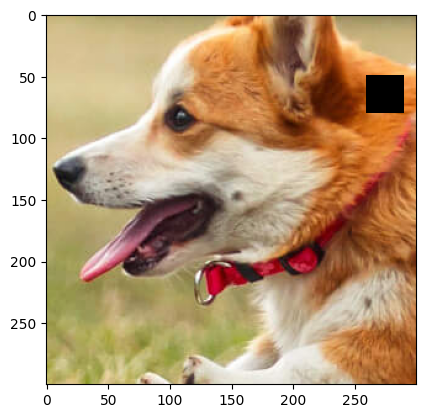

In [12]:
plt.imshow(image_tensor_with_nan_patch.cpu().permute(1,2,0)/255)

In [26]:
import numpy as np

def factorize_color(A, k, device=torch.device('cpu'),epsilon=0.01):
    """Factorize the matrix D into A and B"""
    _,m,n = A.shape

    # Randomly initialize factors
    WR = torch.randn(m, k, device=device)
    HR = torch.randn(k, n, device=device)
    WG = torch.randn(m, k, device=device)
    HG = torch.randn(k, n, device=device)
    WB = torch.randn(m, k, device=device)
    HB = torch.randn(k, n, device=device)

    maskR = ~torch.isnan(A[0,:, :])
    maskG = ~torch.isnan(A[1,:, :])
    maskB = ~torch.isnan(A[2,:, :])

    # Train the model
    prev_loss = np.inf
    losses = []
    steps = 0
    while steps<20:
        # Update H
        for j in range(n):
            HR[:,j]= torch.linalg.lstsq(WR[maskR[:,j],:], A[0][maskR[:,j],j]).solution
            HG[:,j]= torch.linalg.lstsq(WG[maskG[:,j],:], A[1][maskG[:,j],j]).solution
            HB[:,j]= torch.linalg.lstsq(WB[maskB[:,j],:], A[2][maskB[:,j],j]).solution

        # Update W
        for i in range(m):
            WR[i,:]= torch.linalg.lstsq(HR[:,maskR[i,:]].t(), A[0][i,maskR[i,:]].t()).solution.t()
            WG[i,:]= torch.linalg.lstsq(HG[:,maskG[i,:]].t(), A[1][i,maskG[i,:]].t()).solution.t()
            WB[i,:]= torch.linalg.lstsq(HB[:,maskB[i,:]].t(), A[2][i,maskB[i,:]].t()).solution.t()


        # Compute the loss
        diff_matrixR = torch.mm(WR, HR) - A[0,:,:]
        diff_vectorR = diff_matrixR[maskR]
        lossR = torch.norm(diff_vectorR)
        diff_matrixG = torch.mm(WG, HG) - A[1,:,:]
        diff_vectorG = diff_matrixG[maskG]
        lossG = torch.norm(diff_vectorG)
        diff_matrixB = torch.mm(WB, HB) - A[2,:,:]
        diff_vectorB = diff_matrixB[maskB]
        lossB = torch.norm(diff_vectorB)
        loss = lossR + lossG + lossB
        print(loss)
        if abs(prev_loss - loss) < epsilon:
            break
        steps += 1
        prev_loss = loss

    return (WR, HR, WG, HG, WB, HB), losses

weights, losses = factorize_color(image_tensor_with_nan_patch, 75,device)

tensor(4568.2026)
tensor(2596.4504)
tensor(2438.9768)
tensor(2390.9958)
tensor(2369.5991)
tensor(2357.7871)
tensor(2350.2910)
tensor(2345.1216)
tensor(2341.3860)
tensor(2338.6184)
tensor(2336.5327)
tensor(2334.9304)
tensor(2333.6663)
tensor(2332.6404)
tensor(2331.7830)
tensor(2331.0496)
tensor(2330.4087)
tensor(2329.8413)
tensor(2329.3315)
tensor(2328.8704)


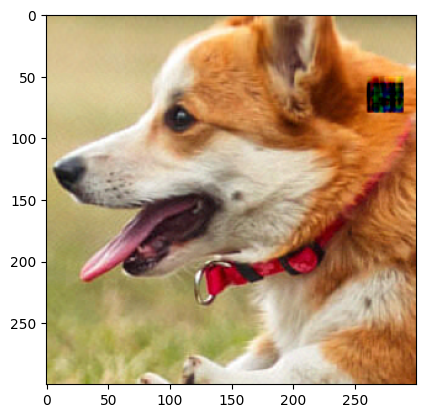

In [24]:

WR,HR,WG,HG,WB,HB=weights
pred_imgR=torch.mm(WR, HR).cpu().detach()
pred_imgG=torch.mm(WG, HG).cpu().detach()
pred_imgB=torch.mm(WB, HB).cpu().detach()
image = np.stack((pred_imgR,pred_imgG,pred_imgB),axis=0)
pred_image = torch.tensor(image)
plt.imshow(pred_image.permute(1,2,0)/255)


In [28]:
PSNR = peak_signal_noise_ratio((crop/255).numpy(), (pred_image/255).numpy())
PSNR

23.539679061712704

In [27]:
rmse = np.sqrt(mean_squared_error((crop/255).numpy(), (pred_image/255).numpy()))
rmse

0.06652977380903954

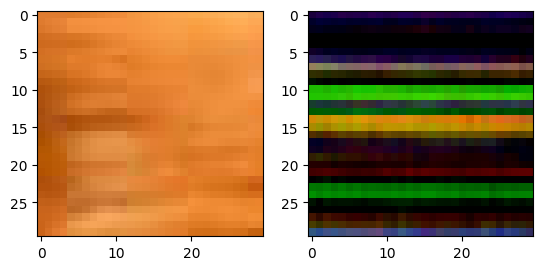

In [15]:
extracted_patch = extract_patch(crop, patch_loc, patch_size)
extracted_patch_pred = extract_patch(pred_image, patch_loc, patch_size)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(extracted_patch.permute(1, 2, 0)/255)
plt.subplot(1,2,2)
plt.imshow(extracted_patch_pred.permute(1, 2, 0)/255)

In [28]:

import random

def add_n_random_nans(image, n, device=torch.device('cpu')):
    # Convert image to tensor if it's not already
    if not torch.is_tensor(image):
        image = torch.tensor(image)

    # Get image dimensions
    num_channels, height, width = image.shape

    # Flatten image tensor
    flat_image = image.reshape(num_channels, -1)

    # Generate random indices for n pixels
    indices = random.sample(range(height * width), n)

    # Set values at selected indices to NaN for each channel
    for channel in range(num_channels):
        flat_image[channel][indices] = float('nan')

    # Reshape the flattened tensor to original shape
    image_with_nans = flat_image.reshape(num_channels, height, width)

    return image_with_nans.to(device)

image_with_nans = add_n_random_nans(crop, 900,device)



In [23]:
image_with_nans=image_with_nans.to(device)

/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


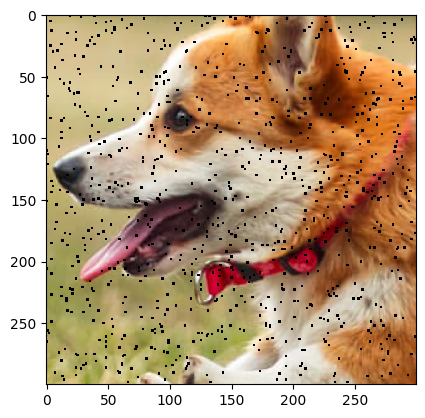

In [21]:
plt.imshow(image_with_nans.cpu().permute(1,2,0)/255)

tensor(9979.1006, device='cuda:0')
tensor(2389.5869, device='cuda:0')
tensor(2382.7012, device='cuda:0')
tensor(2381.9448, device='cuda:0')


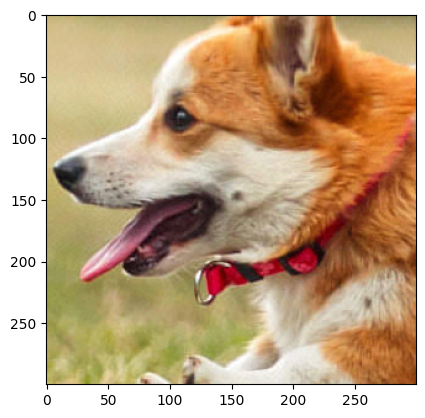

In [24]:
weights, losses = factorize_color(image_with_nans, 75, device)
WR,HR,WG,HG,WB,HB=weights
pred_imgR=torch.mm(WR, HR).cpu().detach()
pred_imgG=torch.mm(WG, HG).cpu().detach()
pred_imgB=torch.mm(WB, HB).cpu().detach()
image = np.stack((pred_imgR,pred_imgG,pred_imgB),axis=0)
pred_image = torch.tensor(image)
plt.imshow(pred_image.permute(1,2,0)/255)


In [19]:
PSNR = peak_signal_noise_ratio((crop/255).numpy(), (pred_image/255).numpy())
PSNR

23.916079753919803

In [20]:
rmse = np.sqrt(mean_squared_error((crop/255).numpy(), (pred_image/255).numpy()))
rmse

0.06370829938886696

In [30]:
patch_loc=(50,200)
patch_sizes = [20, 40, 60, 80]
patches=[]
inp_images_rect=[]
inp_images_rand=[]
pred_images_rect=[]
pred_images_rand=[]
for patch_size in patch_sizes:
  # Make the patch region NaN values
  n = patch_size * patch_size  # Number of random pixels to change to NaN
  image_with_nans = add_n_random_nans(crop, n, device)
  inp_images_rand.append(image_with_nans)
  image_tensor_with_nan_patch = make_patch_nan(crop, patch_loc, patch_size, device)
  inp_images_rect.append(image_tensor_with_nan_patch)
  patches.append(extract_patch(crop, patch_loc, patch_size))
  weights, losses = factorize_color(image_tensor_with_nan_patch, 75, device)
  WR,HR,WG,HG,WB,HB=weights
  pred_imgR=torch.mm(WR, HR).cpu().detach()
  pred_imgG=torch.mm(WG, HG).cpu().detach()
  pred_imgB=torch.mm(WB, HB).cpu().detach()
  image = np.stack((pred_imgR,pred_imgG,pred_imgB),axis=0)
  pred_image = torch.tensor(image)
  pred_images_rect.append(pred_image)
  weights, losses = factorize_color(image_with_nans, 75, device)
  WR,HR,WG,HG,WB,HB=weights
  pred_imgR=torch.mm(WR, HR).cpu().detach()
  pred_imgG=torch.mm(WG, HG).cpu().detach()
  pred_imgB=torch.mm(WB, HB).cpu().detach()
  image = np.stack((pred_imgR,pred_imgG,pred_imgB),axis=0)
  pred_image = torch.tensor(image)
  pred_images_rand.append(pred_image)


tensor(4586.4277, device='cuda:0')
tensor(2377.6702, device='cuda:0')
tensor(2371.2830, device='cuda:0')
tensor(2369.6689, device='cuda:0')
tensor(2368.9395, device='cuda:0')
tensor(2368.6631, device='cuda:0')
tensor(2368.5264, device='cuda:0')
tensor(8002.8984, device='cuda:0')
tensor(2402.5120, device='cuda:0')
tensor(2399.0115, device='cuda:0')
tensor(2397.6475, device='cuda:0')
tensor(2397.2166, device='cuda:0')
tensor(4529.4639, device='cuda:0')
tensor(2283.7971, device='cuda:0')
tensor(2273.5549, device='cuda:0')
tensor(2270.1602, device='cuda:0')
tensor(2268.3462, device='cuda:0')
tensor(2267.3611, device='cuda:0')
tensor(2266.7837, device='cuda:0')
tensor(2266.3867, device='cuda:0')
tensor(2266.0647, device='cuda:0')
tensor(2265.7659, device='cuda:0')
tensor(2265.4673, device='cuda:0')
tensor(2265.1648, device='cuda:0')
tensor(2264.8584, device='cuda:0')
tensor(2264.5388, device='cuda:0')
tensor(2264.1899, device='cuda:0')
tensor(2263.8093, device='cuda:0')
tensor(2263.4299, de

/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


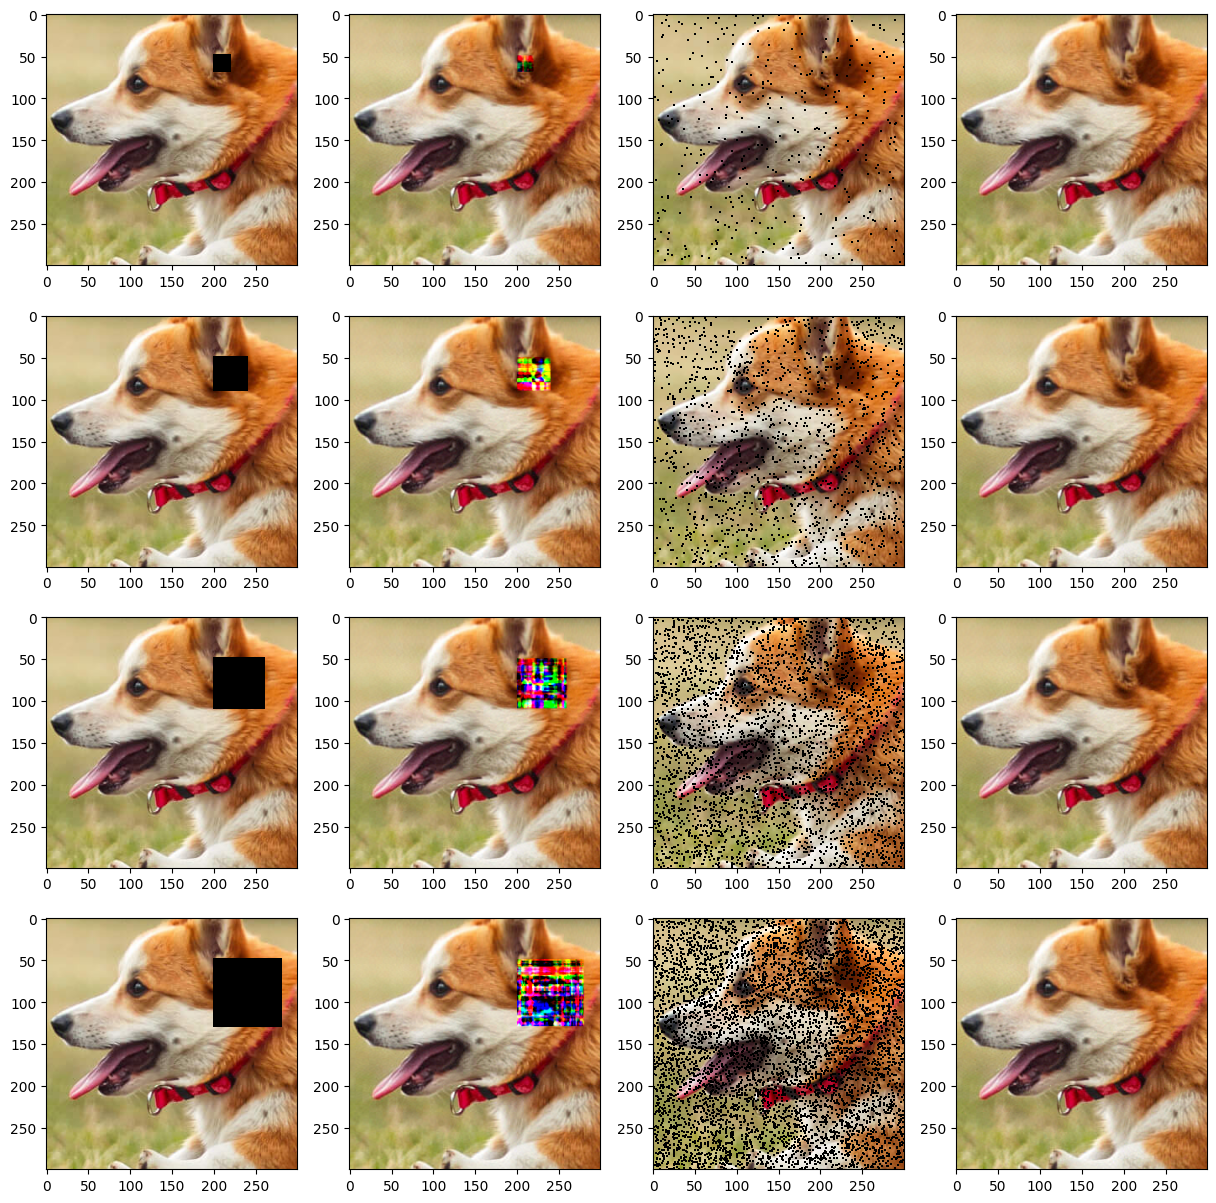

In [32]:
plt.figure(figsize=(15,15))
for i in range(len(patch_sizes)):
  plt.subplot(len(patch_sizes),4,i*4+1)
  plt.imshow(inp_images_rect[i].cpu().permute(1,2,0)/255)
  plt.subplot(len(patch_sizes),4,i*4+2)
  plt.imshow(pred_images_rect[i].cpu().permute(1,2,0)/255)
  plt.subplot(len(patch_sizes),4,i*4+3)
  plt.imshow(inp_images_rand[i].cpu().permute(1,2,0)/255)
  plt.subplot(len(patch_sizes),4,i*4+4)
  plt.imshow(pred_images_rand[i].cpu().permute(1,2,0)/255)


In [18]:
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio

In [38]:
for i in range(4):
  rmse = np.sqrt(mean_squared_error((crop/255).numpy(), (pred_images_rect[i]/255).numpy()))
  print(f"RMSE of rectangular patch for Patch size {patch_sizes[i]} :", rmse,"\n")
  rmse = np.sqrt(mean_squared_error((crop/255).numpy(), (pred_images_rand[i]/255).numpy()))
  print(f"RMSE of randomly removed data for Patch size {patch_sizes[i]} :", rmse,"\n")


RMSE of rectangular patch for Patch size 20 : 0.03330493786747806 

RMSE of randomly removed data for Patch size 20 : 0.010523678995431569 

RMSE of rectangular patch for Patch size 40 : 0.13794481248409218 

RMSE of randomly removed data for Patch size 40 : 0.010689902053731779 

RMSE of rectangular patch for Patch size 60 : 0.16180893273803715 

RMSE of randomly removed data for Patch size 60 : 0.0109997096814177 

RMSE of rectangular patch for Patch size 80 : 0.2529806928354129 

RMSE of randomly removed data for Patch size 80 : 0.011427939056808707 



In [41]:
for i in range(4):
  PSNR = peak_signal_noise_ratio((crop/255).numpy(), (pred_images_rect[i]/255).numpy())
  print(f"PSNR of rectangular patch for Patch size {patch_sizes[i]} :", PSNR,"\n")
  PSNR = peak_signal_noise_ratio((crop/255).numpy(), (pred_images_rand[i]/255).numpy())
  print(f"PSNR of randomly removed data for Patch size {patch_sizes[i]} :", PSNR,"\n")

PSNR of rectangular patch for Patch size 20 : 29.54982744421787 

PSNR of randomly removed data for Patch size 20 : 39.55664815402798 

PSNR of rectangular patch for Patch size 40 : 17.20589253680852 

PSNR of randomly removed data for Patch size 40 : 39.42052547995669 

PSNR of rectangular patch for Patch size 60 : 15.819950132626632 

PSNR of randomly removed data for Patch size 60 : 39.1723755430576 

PSNR of rectangular patch for Patch size 80 : 11.938252447234577 

PSNR of randomly removed data for Patch size 80 : 38.84064168598586 



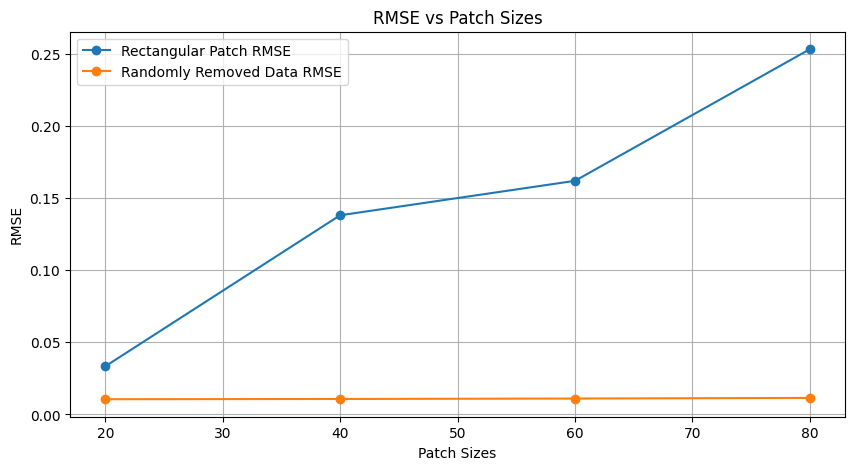

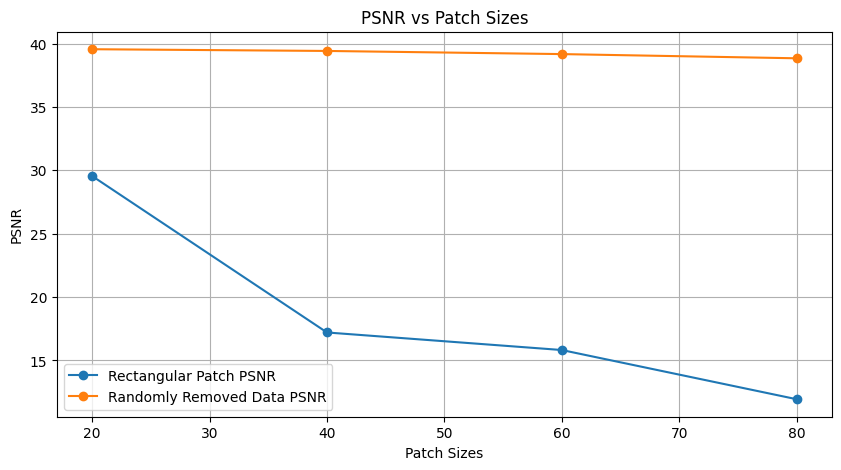

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# RMSE and PSNR values for rectangular patch and randomly removed data
rmse_rect = [0.03330493786747806, 0.13794481248409218, 0.16180893273803715, 0.2529806928354129]
rmse_rand = [0.010523678995431569, 0.010689902053731779, 0.0109997096814177, 0.011427939056808707]

psnr_rect = [29.54982744421787, 17.20589253680852, 15.819950132626632, 11.938252447234577]
psnr_rand = [39.55664815402798, 39.42052547995669, 39.1723755430576, 38.84064168598586]

patch_sizes = [20, 40, 60, 80]

# Plotting RMSE vs Patch Sizes
plt.figure(figsize=(10, 5))
plt.plot(patch_sizes, rmse_rect, marker='o', label='Rectangular Patch RMSE')
plt.plot(patch_sizes, rmse_rand, marker='o', label='Randomly Removed Data RMSE')
plt.title('RMSE vs Patch Sizes')
plt.xlabel('Patch Sizes')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

# Plotting PSNR vs Patch Sizes
plt.figure(figsize=(10, 5))
plt.plot(patch_sizes, psnr_rect, marker='o', label='Rectangular Patch PSNR')
plt.plot(patch_sizes, psnr_rand, marker='o', label='Randomly Removed Data PSNR')
plt.title('PSNR vs Patch Sizes')
plt.xlabel('Patch Sizes')
plt.ylabel('PSNR')
plt.legend()
plt.grid(True)
plt.show()
